In [160]:
import json
import numpy as np
from preprocess_data.process_ground_truth import reform_ground_truth, ground_truth_sep
import tensorflow as tf
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from hyperopt import hp, fmin, tpe, Trials
from tensorflow.keras.optimizers import Adam

In [161]:
with open('/Users/ruotsing/PycharmProjects/DMS/preprocess_data/lateral_acceleration_data.json', 'r') as f:
    LA_data = json.load(f)
    
with open('/Users/ruotsing/PycharmProjects/DMS/preprocess_data/SWA_data.json', 'r') as f:
    SWA_data = json.load(f)

with open('/Users/ruotsing/PycharmProjects/DMS/preprocess_data/lateral_displacement_data.json', 'r') as f:
    LD_data = json.load(f)
    
with open('/Users/ruotsing/PycharmProjects/DMS/preprocess_data/YA_data.json', 'r') as f:
    YA_data = json.load(f)
    
with open('/Users/ruotsing/PycharmProjects/DMS/preprocess_data/ground_truth.json', 'r') as f:
    ground_truth = json.load(f)
    
def time_derivative(data, time_interval):
    data_dt = {}
    for name in data.keys():
        delta_displacement = np.diff(data[name])
        data_dt[name] = np.gradient(delta_displacement, time_interval)
    return data_dt

sample_rate = 100
SWV_data= time_derivative(SWA_data, 1/sample_rate)
YR_data= time_derivative(YA_data, 1/sample_rate)

#standardize the data
def standardize(data):
    data_standard = {}
    for name in data.keys():
        data_standard[name] = (data[name] - np.mean(data[name]))/np.std(data[name])
    return data_standard

YR_standard = standardize(YR_data)
SWA_standard = standardize(SWA_data)
SWV_standard = standardize(SWV_data)
LD_standard = standardize(LD_data)
LA_standard = standardize(LA_data)

#apply the time window
size_= 10
step = 1
ground_truth=reform_ground_truth(ground_truth)
awake_window, light_drowsy_window, drowsy_window=ground_truth_sep(ground_truth,size_,step)

def define_feature_matrix(window, data):
    feature_matrix = []
    for name in window.keys():
        for i in range(len(window[name])):
            begin = window[name][i][0]*sample_rate
            end = (window[name][i][-1]+1)*sample_rate
            feature_matrix.append(data[name][begin:end])
    return np.array(feature_matrix)
    

awake_YR_feature = define_feature_matrix(awake_window, YR_standard)
awake_SWA_feature = define_feature_matrix(awake_window, SWA_standard)
awake_SWV_feature = define_feature_matrix(awake_window, SWV_standard)
awake_LD_feature = define_feature_matrix(awake_window, LD_standard)
awake_LA_feature = define_feature_matrix(awake_window, LA_standard)
awake_feature_matrix=np.dstack((awake_YR_feature, awake_SWA_feature, awake_SWV_feature, awake_LD_feature, awake_LA_feature))
awake_label = np.ones(awake_feature_matrix.shape[0])

light_drowsy_YR_feature = define_feature_matrix(light_drowsy_window, YR_standard)
light_drowsy_SWA_feature = define_feature_matrix(light_drowsy_window, SWA_standard)
light_drowsy_SWV_feature = define_feature_matrix(light_drowsy_window, SWV_standard)
light_drowsy_LD_feature = define_feature_matrix(light_drowsy_window, LD_standard)
light_drowsy_LA_feature = define_feature_matrix(light_drowsy_window, LA_standard)
light_drowsy_feature_matrix=np.dstack((light_drowsy_YR_feature, light_drowsy_SWA_feature, light_drowsy_SWV_feature, light_drowsy_LD_feature, light_drowsy_LA_feature))
light_drowsy_label = np.ones(light_drowsy_feature_matrix.shape[0])*2

drowsy_YR_feature = define_feature_matrix(drowsy_window, YR_standard)
drowsy_SWA_feature = define_feature_matrix(drowsy_window, SWA_standard)
drowsy_SWV_feature = define_feature_matrix(drowsy_window, SWV_standard)
drowsy_LD_feature = define_feature_matrix(drowsy_window, LD_standard)
drowsy_LA_feature = define_feature_matrix(drowsy_window, LA_standard)
drowsy_feature_matrix=np.dstack((drowsy_YR_feature, drowsy_SWA_feature, drowsy_SWV_feature, drowsy_LD_feature, drowsy_LA_feature))
drowsy_label=np.ones(drowsy_feature_matrix.shape[0])*3


feature_matrix=np.concatenate((awake_feature_matrix, light_drowsy_feature_matrix, drowsy_feature_matrix), axis=0)
label=np.concatenate((awake_label, light_drowsy_label, drowsy_label), axis=0)
# label=tf.keras.utils.to_categorical(label-1, num_classes=3)
label=label-1
label=label.astype(int)

X_train, X_test, y_train, y_test = train_test_split(feature_matrix, label, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

def make_model(space,best_params):
    Input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
    model= tf.keras.models.Sequential([
        Input_layer,
        # filters, kernel_size, activation, input_shape
        tf.keras.layers.Conv1D(space['conv_filters_1'][best_params['conv_filters_1']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        # window size
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_2'][best_params['conv_filters_2']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_3'][best_params['conv_filters_3']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_4'][best_params['conv_filters_4']], 3, activation=None, input_shape=(X_train.shape[1], X_train.shape[2])),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    return model
def confusion_matrix_on_test_data(model,model_name, X_test, y_test):
    y_pred=[]
    for row in model.predict(X_test):
        y_pred.append(np.argmax(row))
    y_pred=np.array(y_pred)    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 1', 'Class 2', 'Class 3'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix of '+model_name)
    plt.show()

In [162]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / len(awake_label)) * (len(label) / 3.0)
weight_for_1 = (1 / len(light_drowsy_label)) * (len(label) / 3.0)
weight_for_2 = (1 / len(drowsy_label)) * (len(label) / 3.0)
# weight_for_0 = 1
# weight_for_1 = 2
# weight_for_2 = 3


class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}


In [171]:
#define search space
space = {
    'conv_filters_1': hp.choice('conv_filters_1', [16, 32, 64, 128]),
    'conv_filters_2': hp.choice('conv_filters_2', [16, 32, 64, 128]),
    'conv_filters_3': hp.choice('conv_filters_3', [16, 32, 64, 128]),
    'conv_filters_4': hp.choice('conv_filters_4', [16, 32, 64, 128]),
    'mini_batch_size': hp.choice('mini_batch_size', [16, 32, 64, 128]),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.01),
    'pooling_size_hyperopt': hp.choice('pooling_size_hyperopt', [2,3]),
    'neurons_lstm': hp.choice('neurons_lstm', [16, 32, 64, 128]),
    'neurons_gru': hp.choice('neurons_gru', [16, 32, 64, 128])
}

space_params = {
    'conv_filters_1': [16, 32, 64, 128],
    'conv_filters_2': [16, 32, 64, 128],
    'conv_filters_3': [16, 32, 64, 128],
    'conv_filters_4': [16, 32, 64, 128],
    'mini_batch_size': [16, 32, 64, 128],
    'pooling_size_hyperopt': [2,3],
    'neurons_lstm': [16, 32, 64, 128],
    'neurons_gru': [16, 32, 64, 128]
}


In [144]:

def objective(params):
    Input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
    model= tf.keras.models.Sequential([
        Input_layer,
        tf.keras.layers.Conv1D(params['conv_filters_1'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_2'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_3'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_4'], 3, activation=None, input_shape=(X_train.shape[1], X_train.shape[2])),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    model.fit(X_train, y_train, epochs=5, batch_size=params['mini_batch_size'], validation_data=(X_val, y_val), verbose=0)
    _, val_acc = model.evaluate(X_val, y_val, verbose=0)
    return -val_acc  # Hyperopt minimizes the objective function

trials = Trials()
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=10, trials=trials)

print("Best hyperparameters:", best_params)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



100%|██████████| 10/10 [10:05<00:00, 60.58s/trial, best loss: -0.825941801071167]
Best hyperparameters: {'conv_filters_1': 0, 'conv_filters_2': 2, 'conv_filters_3': 0, 'conv_filters_4': 1, 'learning_rate': 0.004433533487427123, 'mini_batch_size': 1, 'pooling_size_hyperopt': 0}


116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


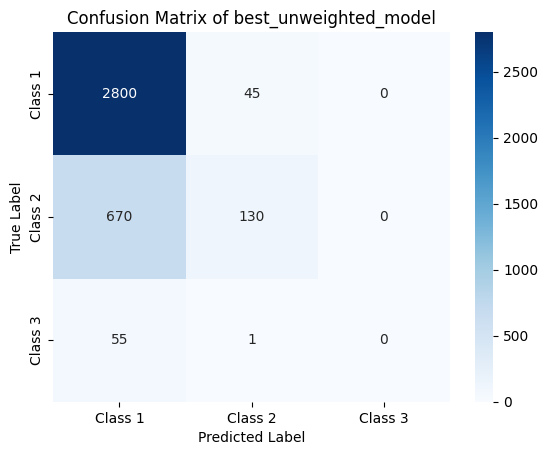

In [145]:
best_unweighted_model = make_model(space_params, best_params)
best_unweighted_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val), verbose=0)
confusion_matrix_on_test_data(best_unweighted_model, 'best_unweighted_model', X_test, y_test)

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



100%|██████████| 30/30 [24:36<00:00, 49.21s/trial, best loss: -0.7682403326034546]
Best hyperparameters: {'conv_filters_1': 1, 'conv_filters_2': 1, 'conv_filters_3': 2, 'conv_filters_4': 1, 'learning_rate': 0.004253616464946108, 'mini_batch_size': 1, 'pooling_size_hyperopt': 1}
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


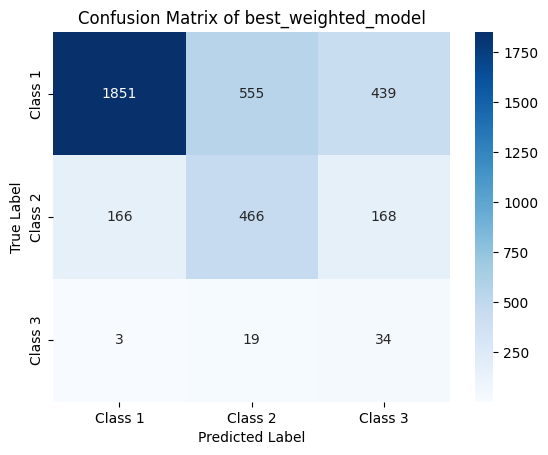

In [164]:
def objective_weighted(params):
    Input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
    model= tf.keras.models.Sequential([
        Input_layer,
        tf.keras.layers.Conv1D(params['conv_filters_1'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_2'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_3'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_4'], 3, activation=None, input_shape=(X_train.shape[1], X_train.shape[2])),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    model.fit(X_train, y_train, epochs=5, batch_size=params['mini_batch_size'], validation_data=(X_val, y_val), verbose=0, class_weight=class_weight)
    _, val_acc = model.evaluate(X_val, y_val, verbose=0)
    return -val_acc  # Hyperopt minimizes the objective function

trials = Trials()
best_params_weighted = fmin(objective_weighted, space, algo=tpe.suggest, max_evals=30, trials=trials)

print("Best hyperparameters:", best_params_weighted)
best_weighted_model = make_model(space_params, best_params_weighted)
best_weighted_model.fit(X_train, y_train, epochs=5, batch_size=space_params['mini_batch_size'][best_params_weighted['mini_batch_size']], validation_data=(X_val, y_val), verbose=0, class_weight=class_weight)
confusion_matrix_on_test_data(best_weighted_model, 'best_weighted_model', X_test, y_test)

In [ ]:
np.random.seed(42)
selected_awake_cases=len(drowsy_label)
selected_light_drowsy_cases=len(drowsy_label)
selected_awake_indices=np.random.choice(awake_feature_matrix.shape[0], selected_awake_cases, replace=False)
selected_light_drowsy_indices=np.random.choice(light_drowsy_feature_matrix.shape[0], selected_light_drowsy_cases, replace=False)
selected_awake_feature_matrix=awake_feature_matrix[selected_awake_indices]
selected_light_drowsy_feature_matrix=light_drowsy_feature_matrix[selected_light_drowsy_indices]
downsample_feature_matrix=np.concatenate((selected_awake_feature_matrix, selected_light_drowsy_feature_matrix, drowsy_feature_matrix), axis=0)
downsample_label=np.concatenate((np.ones(selected_awake_cases), np.ones(selected_light_drowsy_cases)*2, np.ones(len(drowsy_label))*3), axis=0)
downsample_label=downsample_label-1
downsample_label=downsample_label.astype(int)

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(downsample_feature_matrix, downsample_label, test_size=0.15, random_state=42)
X_train_d, X_val_d, y_train_d, y_val_d = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [137]:
trials = Trials()
best_params_downsampled = fmin(objective, space, algo=tpe.suggest, max_evals=30, trials=trials)

print("Best hyperparameters:", best_params_downsampled)

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



100%|██████████| 30/30 [18:04<00:00, 36.14s/trial, best loss: -0.8079642057418823]
Best hyperparameters: {'conv_filters_1': 0, 'conv_filters_2': 3, 'conv_filters_3': 2, 'conv_filters_4': 1, 'learning_rate': 0.002375654342871365, 'mini_batch_size': 2, 'pooling_size_hyperopt': 0}


In [135]:
trials = Trials()
best_params_downsampled_weighted = fmin(objective_weighted, space, algo=tpe.suggest, max_evals=10, trials=trials)

print("Best hyperparameters:", best_params_downsampled_weighted)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



100%|██████████| 10/10 [06:26<00:00, 38.62s/trial, best loss: -0.8060791492462158]
Best hyperparameters: {'conv_filters_1': 3, 'conv_filters_2': 1, 'conv_filters_3': 0, 'conv_filters_4': 0, 'learning_rate': 0.0026102282232864935, 'mini_batch_size': 1, 'pooling_size_hyperopt': 1}


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


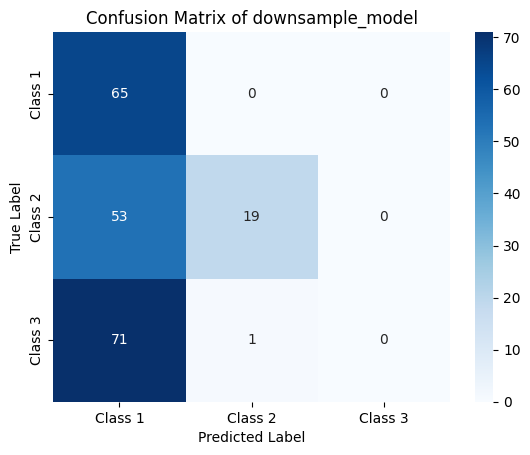

In [138]:

downsample_model = make_model(space_params, best_params_downsampled)
downsample_model.fit(X_train_d, y_train_d, epochs=5, batch_size=space_params['mini_batch_size'][best_params_downsampled['mini_batch_size']], validation_data=(X_val_d, y_val_d), verbose=0)
confusion_matrix_on_test_data(downsample_model, 'downsample_model', X_test_d, y_test_d)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


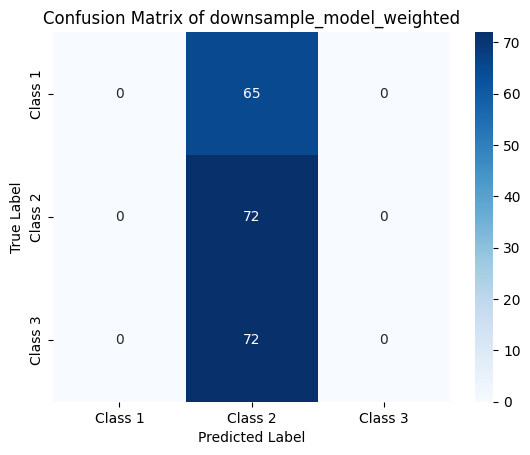

In [136]:
downsample_model_weighted = make_model(space_params, best_params_downsampled_weighted)
downsample_model.fit(X_train_d, y_train_d, epochs=5, batch_size=space_params['mini_batch_size'][best_params_downsampled_weighted['mini_batch_size']], validation_data=(X_val_d, y_val_d), verbose=0)
confusion_matrix_on_test_data(downsample_model_weighted, 'downsample_model_weighted', X_test_d, y_test_d)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



100%|██████████| 20/20 [21:53<00:00, 65.69s/trial, best loss: -0.7701478004455566]
Best hyperparameters: {'conv_filters_1': 2, 'conv_filters_2': 0, 'conv_filters_3': 1, 'conv_filters_4': 2, 'learning_rate': 0.0014298132833256575, 'mini_batch_size': 3, 'neurons_gru': 2, 'neurons_lstm': 3, 'pooling_size_hyperopt': 1}
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


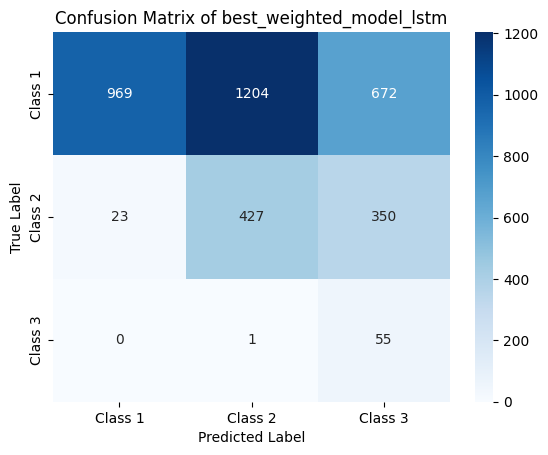

In [176]:
def make_model_lstm(space,best_params):
    Input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
    model= tf.keras.models.Sequential([
        Input_layer,
        # filters, kernel_size, activation, input_shape
        tf.keras.layers.Conv1D(space['conv_filters_1'][best_params['conv_filters_1']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        # window size
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_2'][best_params['conv_filters_2']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_3'][best_params['conv_filters_3']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_4'][best_params['conv_filters_4']], 3, activation=None, input_shape=(X_train.shape[1], X_train.shape[2])),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.LSTM(space['neurons_lstm'][best_params['neurons_lstm']]),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    return model
    
def objective_weighted_lstm(params):
    Input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
    model= tf.keras.models.Sequential([
        Input_layer,
        tf.keras.layers.Conv1D(params['conv_filters_1'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_2'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_3'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_4'], 3, activation=None, input_shape=(X_train.shape[1], X_train.shape[2])),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.LSTM(params['neurons_lstm']),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    model.fit(X_train, y_train, epochs=5, batch_size=params['mini_batch_size'], validation_data=(X_val, y_val), verbose=0, class_weight=class_weight)
    _, val_acc = model.evaluate(X_val, y_val, verbose=0)
    return -val_acc  # Hyperopt minimizes the objective function

trials = Trials()
best_params_weighted_lstm = fmin(objective_weighted, space, algo=tpe.suggest, max_evals=20, trials=trials)

print("Best hyperparameters:", best_params_weighted_lstm)
best_weighted_model_lstm = make_model_lstm(space_params, best_params_weighted_lstm)
best_weighted_model_lstm.fit(X_train, y_train, epochs=5, batch_size=space_params['mini_batch_size'][best_params_weighted_lstm['mini_batch_size']], validation_data=(X_val, y_val), verbose=0, class_weight=class_weight)
confusion_matrix_on_test_data(best_weighted_model_lstm, 'best_weighted_model_lstm', X_test, y_test)    

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



100%|██████████| 10/10 [13:04<00:00, 78.48s/trial, best loss: -0.6931330561637878]
Best hyperparameters: {'conv_filters_1': 3, 'conv_filters_2': 1, 'conv_filters_3': 3, 'conv_filters_4': 1, 'learning_rate': 0.0015982423166011803, 'mini_batch_size': 3, 'neurons_gru': 0, 'neurons_lstm': 1, 'pooling_size_hyperopt': 0}
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


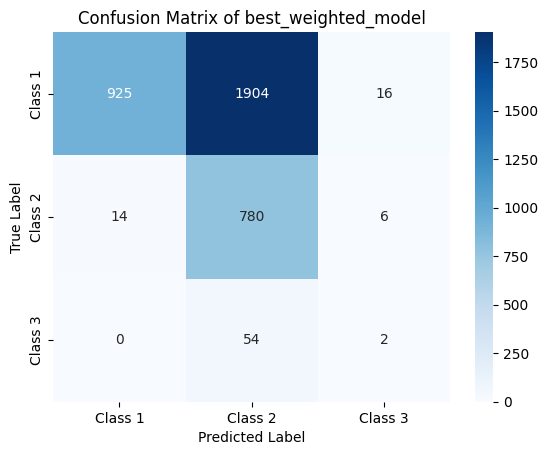

In [174]:
def make_model_gru(space,best_params):
    Input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
    model= tf.keras.models.Sequential([
        Input_layer,
        # filters, kernel_size, activation, input_shape
        tf.keras.layers.Conv1D(space['conv_filters_1'][best_params['conv_filters_1']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        # window size
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_2'][best_params['conv_filters_2']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_3'][best_params['conv_filters_3']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_4'][best_params['conv_filters_4']], 3, activation=None, input_shape=(X_train.shape[1], X_train.shape[2])),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.GRU(space['neurons_gru'][best_params['neurons_gru']]),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    return model
    
def objective_weighted_gru(params):
    Input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
    model= tf.keras.models.Sequential([
        Input_layer,
        tf.keras.layers.Conv1D(params['conv_filters_1'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_2'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_3'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_4'], 3, activation=None, input_shape=(X_train.shape[1], X_train.shape[2])),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.LSTM(params['neurons_gru']),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    model.fit(X_train, y_train, epochs=5, batch_size=params['mini_batch_size'], validation_data=(X_val, y_val), verbose=0, class_weight=class_weight)
    _, val_acc = model.evaluate(X_val, y_val, verbose=0)
    return -val_acc  # Hyperopt minimizes the objective function

trials = Trials()
best_params_weighted_gru = fmin(objective_weighted_gru, space, algo=tpe.suggest, max_evals=10, trials=trials)

print("Best hyperparameters:", best_params_weighted_gru)
best_weighted_model_gru = make_model_gru(space_params, best_params_weighted_gru)
best_weighted_model_gru.fit(X_train, y_train, epochs=5, batch_size=space_params['mini_batch_size'][best_params_weighted_gru['mini_batch_size']], validation_data=(X_val, y_val), verbose=0, class_weight=class_weight)
confusion_matrix_on_test_data(best_weighted_model_gru, 'best_weighted_model', X_test, y_test)    